In [1]:
# import packages
import pandas as pd
import os
import csv
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim.models import ldaseqmodel
import time
from gensim.models.wrappers import DtmModel
import pickle
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [2]:
# construct the stop word list
stopwords = [line.strip() for line in open("stop_words_copy2.txt",encoding='UTF-8').readlines()]

In [3]:
# read in csv file
all_data = pd.read_csv('./all_data.csv', header=None)
# add columns
all_data.columns = ["year", "title", "article"]
# sort by year
all_data = all_data.sort_values(by=['year'])
# change index
new_index = np.arange(0, len(all_data))
all_data["new_index"] = new_index
all_data = all_data.set_index('new_index')

In [4]:
# construct the function that preprocess the text
def preprocess(text):
    '''
    Preprocess the text by tokenizing the string into uni-grams, deleting all 
    numbers, punctuations and stop words. Store the preprocessed sting into 
    a list of words
    
    input: 
        text: text for preprocessing(str)
    output: a list of words
    '''
    result = []
    tokens = gensim.utils.tokenize(text)
    tokens_lst = list(tokens)
    for token in tokens_lst:
        if token not in stopwords:
            result.append(token)
            
    return result

In [5]:
# preprocess the data
processed_df = all_data['article'].map(preprocess)

In [6]:
# prepare Document-Term Matrix for the DTA model 
# Create Dictionaries for unique word counts of each decade
dic_all = corpora.Dictionary(processed_df)

# Create Corpus: Term Document Frequency
corpus_all = [dic_all.doc2bow(text) for text in processed_df]

In [7]:
# set the time slice
all_data[all_data['year']==1958]
# before 60s: 0-35
all_data[all_data['year']==1978]
# before 1979: 36-70
all_data[all_data['year']==1989]
# before 1990: 71-876
all_data[all_data['year']==2003]
# before 2003: 877-1811
time_slice = [71, 806, 935]

In [38]:
# fit the 5-topic model
start = time.time()
ldaseq_5 = ldaseqmodel.LdaSeqModel(corpus=corpus_all, id2word=dic_all, time_slice=time_slice, 
                                    num_topics=5, chain_variance=0.1, random_state=100)
end = time.time()
print(end - start)

KeyboardInterrupt: 

In [10]:
# save model
pickle.dump(ldaseq_5, open("ldaseq_model_5.sav", 'wb'))
# check
loaded_model_5 = pickle.load(open("ldaseq_model_5.sav", 'rb'))

In [46]:
# calculate coherence matrix
topics_dtm_5 = ldaseq_5.dtm_coherence(time=0)
cm_DTM_5 = CoherenceModel(topics=topics_dtm_5, corpus=corpus_all, dictionary=dic_all, coherence='u_mass')
print ("U_mass topic coherence")
print ("DTM Python coherence is", cm_DTM_5.get_coherence())

U_mass topic coherence
DTM Python coherence is -1.2071757973686532


In [20]:
# check
loaded_model_5 = pickle.load(open("ldaseq_model_5.sav", 'rb'))

In [45]:
# calculate coherence matrix
topics_dtm = loaded_model_5.dtm_coherence(time=0)
cm_DTM = CoherenceModel(topics=topics_dtm, corpus=corpus_all, dictionary=dic_all, coherence='u_mass')
print ("U_mass topic coherence")
print ("DTM Python coherence is", cm_DTM.get_coherence())

U_mass topic coherence
DTM Python coherence is -1.2071757973686532


In [21]:
doc_topic_5 = []
for doc_num in range(len(all_data)):
    doc = loaded_model_5.doc_topics(doc_num)
    doc_topic_5.append(doc)
topic_df_5 = pd.DataFrame(doc_topic_5, columns=['t1', 't2', 't3', 't4', 't5'])
topic_com_df_5 = pd.concat([all_data, topic_df_5], axis=1, sort=False)
grouped_df_5 = topic_com_df_5.groupby(['year']).sum().reset_index()

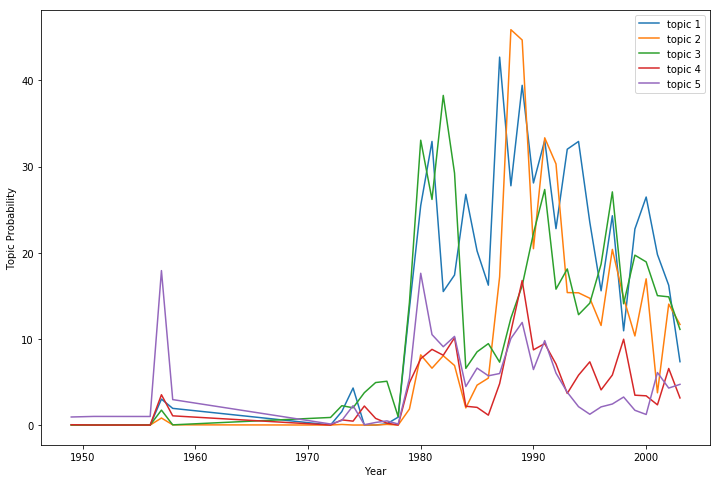

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(grouped_df_5['year'], grouped_df_5['t1'], label='topic 1')
plt.plot(grouped_df_5['year'], grouped_df_5['t2'], label='topic 2')
plt.plot(grouped_df_5['year'], grouped_df_5['t3'], label='topic 3')
plt.plot(grouped_df_5['year'], grouped_df_5['t4'], label='topic 4')
plt.plot(grouped_df_5['year'], grouped_df_5['t5'], label='topic 5')
plt.xlabel("Year")
plt.ylabel("Topic Probability")
plt.legend(loc='best')
plt.show()

In [23]:
# print topic evolution
# evolution of 5th topic
fifth_topic = loaded_model_5.print_topic_times(topic=4) 
fifth_topic

[[('避孕', 0.011052327529917293),
  ('人', 0.008338741256053802),
  ('生育', 0.007740856835031246),
  ('问题', 0.007114407179722771),
  ('工作', 0.005845004725104531),
  ('节育', 0.005685369319982351),
  ('人民', 0.005131720367089456),
  ('进行', 0.004715856044570651),
  ('技术', 0.00443009228685674),
  ('宣传', 0.004395250463504173),
  ('研究', 0.004365183103391378),
  ('方法', 0.004163415198365529),
  ('国家', 0.0041439427678187975),
  ('生活', 0.0041265572361079556),
  ('要求', 0.0039029441235595187),
  ('农民', 0.003881071178624238),
  ('节制', 0.0038755134538340195),
  ('生产', 0.003853142724406788),
  ('工业', 0.003824067619797109),
  ('科学', 0.00382035845231966)],
 [('节育', 0.011091156180994127),
  ('计划生育', 0.01074912490654213),
  ('手术', 0.009835614838582248),
  ('避孕', 0.008472386074755709),
  ('研究', 0.00805255766804606),
  ('妇女', 0.007736240480485788),
  ('岁', 0.0073126659752684375),
  ('技术', 0.006965151563599505),
  ('结婚', 0.005389686008857454),
  ('生育', 0.005009846924446803),
  ('我国', 0.004838940014708197),
  ('人'

In [27]:
# print topic evolution
# evolution of 4th topic
fourth_topic = loaded_model_5.print_topic_times(topic=3) 
fourth_topic

[[('人', 0.03035750307542221),
  ('妇女', 0.014971984790664965),
  ('孩子', 0.012771053351659921),
  ('生', 0.012035439828913714),
  ('斤', 0.010648788894920479),
  ('元', 0.009603196625655869),
  ('职工', 0.009418799392524378),
  ('增加', 0.00930071249491344),
  ('生活', 0.009261361127239924),
  ('生产', 0.007661609435478337),
  ('生育', 0.007657903428912752),
  ('社员', 0.0073895643358330015),
  ('手术', 0.006918499065394947),
  ('平均', 0.006896524125339537),
  ('大队', 0.006854657823691239),
  ('粮食', 0.006446852198791482),
  ('女', 0.00544813455575027),
  ('家庭', 0.005439592388445123),
  ('农村', 0.005076626384291007),
  ('农业', 0.004781117633902267)],
 [('人', 0.023884724378893277),
  ('生', 0.02271851138683786),
  ('孩子', 0.01911485403985287),
  ('元', 0.014652178562350305),
  ('少', 0.008766912009157933),
  ('农民', 0.00853915488315942),
  ('农村', 0.007531019930343204),
  ('粮食', 0.007242107175369164),
  ('生活', 0.006958763699280002),
  ('夫妇', 0.006774501688130066),
  ('大队', 0.006746242949306985),
  ('计划生育', 0.00624050

In [24]:
# evolution of 1st topic
second_topic = loaded_model_5.print_topic_times(topic=0) 
second_topic

[[('人口', 0.06940701113495107),
  ('我国', 0.020402414254547557),
  ('问题', 0.018100744763649056),
  ('发展', 0.016321119488240644),
  ('增长', 0.013681981765850811),
  ('人民', 0.01272792446518364),
  ('国家', 0.012449548003116819),
  ('世界', 0.010160590955958157),
  ('经济', 0.010034040544897416),
  ('人', 0.009825728395133045),
  ('中国', 0.009782503859103514),
  ('生产', 0.008724785085929828),
  ('会议', 0.00795904537663766),
  ('社会', 0.00770881973818743),
  ('解决', 0.006369389245140276),
  ('新', 0.006172499610422955),
  ('政策', 0.005778723457936878),
  ('速度', 0.00514701192255422),
  ('建设', 0.005022171466264639),
  ('代表', 0.004868569761395134)],
 [('人口', 0.07427813187955778),
  ('增长', 0.01823465992976447),
  ('发展', 0.014583827343248474),
  ('我国', 0.01304230862706445),
  ('问题', 0.01084459053552679),
  ('中国', 0.01066941905722888),
  ('国家', 0.010049476048039938),
  ('控制', 0.009640517830909483),
  ('世界', 0.008609122742470762),
  ('经济', 0.008512105315662854),
  ('人', 0.007378498453479673),
  ('亿', 0.0065610405

In [25]:
# evolution of 3rd topic
third_topic = loaded_model_5.print_topic_times(topic=2) 
third_topic

[[('计划生育', 0.04639735549756715),
  ('工作', 0.04424027311568156),
  ('群众', 0.011709175865970305),
  ('宣传', 0.01079085913227474),
  ('思想', 0.009997875267310918),
  ('领导', 0.008598138150286115),
  ('晚婚', 0.00722654155699218),
  ('计划', 0.006827976763147896),
  ('实行', 0.006710641478256612),
  ('开展', 0.006655844327647675),
  ('主席', 0.006251155068476987),
  ('人口', 0.005859291436520735),
  ('各级', 0.005672311166029249),
  ('革命', 0.0054277809038995595),
  ('干部', 0.005347018797308588),
  ('抓', 0.005327030029175121),
  ('新', 0.005310362601853126),
  ('生育', 0.005281304013764045),
  ('提高', 0.005160004112245389),
  ('深入', 0.0051563886392049065)],
 [('计划生育', 0.05201266431064756),
  ('工作', 0.038854741686228766),
  ('群众', 0.013260446974671212),
  ('人口', 0.010776798908794351),
  ('宣传', 0.009665952667732805),
  ('干部', 0.00826114000032774),
  ('实行', 0.007425097182335421),
  ('思想', 0.007263400588472529),
  ('教育', 0.007176227059504221),
  ('生育', 0.007048127884688529),
  ('生', 0.00672487372769244),
  ('夫妇', 0.

In [26]:
# evolution of 2nd topic
second_topic = loaded_model_5.print_topic_times(topic=1) 
second_topic

[[('人口', 0.02804595183051718),
  ('城市', 0.01953357820556964),
  ('计划生育', 0.018372555812822523),
  ('工作', 0.014795121066433194),
  ('人', 0.010438929670800946),
  ('生育', 0.009642215407016673),
  ('出生', 0.007592139946815141),
  ('全省', 0.006962639614729147),
  ('万', 0.006780895959538683),
  ('干部', 0.00652329106137049),
  ('计划', 0.005754746320623326),
  ('县', 0.005328970607517391),
  ('管理', 0.005150461928744123),
  ('流动', 0.005087173544436327),
  ('部门', 0.005003212199233375),
  ('胎', 0.004792851545829178),
  ('超生', 0.004710858308894302),
  ('去年', 0.004662122678574633),
  ('育龄', 0.004261223652571692),
  ('本报', 0.004188595410964403)],
 [('计划生育', 0.03360381595492404),
  ('人口', 0.017334232190874647),
  ('工作', 0.015256483059773243),
  ('生育', 0.011066420178148167),
  ('人', 0.00986585125261833),
  ('万', 0.008272661983441787),
  ('干部', 0.006563873961866549),
  ('县', 0.006192103548258304),
  ('超生', 0.00586306405917586),
  ('管理', 0.005734092080903544),
  ('计划', 0.005542641049966202),
  ('胎', 0.005484

In [20]:
time_0 = [-1.201, -1.092, -1.207, -1.169, -1.296, -1.171, -1.281, -1.367, -1.407]
time_1 = [ -0.99, -1, -1.04, -1.051, -1.124, -1.155, -1.148, -1.291, -1.348]
time_2 = [-0.933, -1.012, -1.078, -0.982, -1.178, -1.129, -1.281, -1.267, -1.284]
average_time = []
for i in range(9):
    sum_ch = time_0[i] + time_1[i] + time_2[i]
    average_time.append(sum_ch/3)
all_tine = [time_0, time_1, time_2, average_time]
umass_ch = pd.DataFrame(all_tine, columns=['3', '4', '5', '6', '7', '8', '9', '10', '15'])

In [21]:
umass_ch_trans = umass_ch.T.reset_index()

In [84]:
umass_ch_trans

,index,0,1,2,3
0,3t,-1.201,-0.990,-0.933,-1.041333
1,4t,-1.092,-1.000,-1.012,-1.034667
2,5t,-1.207,-1.040,-1.078,-1.108333
3,6t,-1.169,-1.051,-0.982,-1.067333
4,7t,-1.296,-1.124,-1.178,-1.199333
5,8t,-1.171,-1.155,-1.129,-1.151667
6,9t,-1.281,-1.148,-1.281,-1.236667
7,10t,-1.367,-1.291,-1.267,-1.308333
8,15t,-1.407,-1.348,-1.284,-1.346333


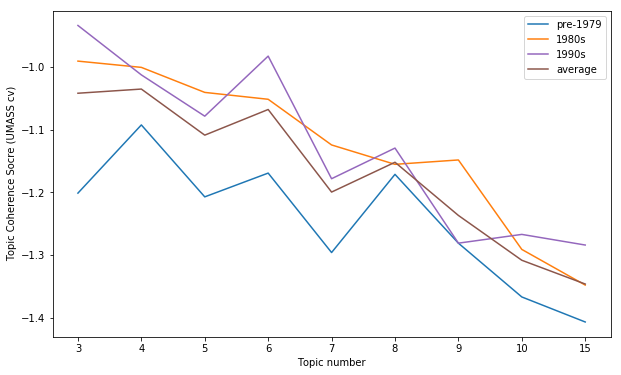

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(umass_ch_trans['index'], umass_ch_trans[0], color='C0', label='pre-1979')
plt.plot(umass_ch_trans['index'], umass_ch_trans[1], color='C1', label='1980s')
plt.plot(umass_ch_trans['index'], umass_ch_trans[2], color='C4', label='1990s')
plt.plot(umass_ch_trans['index'], umass_ch_trans[3], color='C5', label='average')
plt.xlabel("Topic number")
plt.ylabel("Topic Coherence Socre (UMASS cv)")
plt.legend(loc='best')
plt.savefig('./visualization/TOPIC_COHERENCE') 
plt.show()

In [39]:
# fit the 4-topic model
start = time.time()
ldaseq_4 = ldaseqmodel.LdaSeqModel(corpus=corpus_all, id2word=dic_all, time_slice=time_slice, 
                                    num_topics=4, chain_variance=0.1, random_state=100)
end = time.time()
print(end - start)

/Users/ditong/anaconda3/lib/python3.6/site-packages/gensim/models/ldaseqmodel.py:230: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


4796.961621046066


In [47]:
# save model
pickle.dump(ldaseq_4, open("ldaseq_model_4.sav", 'wb'))
# check
loaded_model_4 = pickle.load(open("ldaseq_model_4.sav", 'rb'))

In [60]:
# calculate coherence matrix
topics_dtm_4 = ldaseq_4.dtm_coherence(time=2)
cm_DTM_4 = CoherenceModel(topics=topics_dtm_4, corpus=corpus_all, dictionary=dic_all, coherence='u_mass')
print ("U_mass topic coherence")
print ("DTM Python coherence is", cm_DTM_4.get_coherence())

U_mass topic coherence
DTM Python coherence is -1.0118572526614078


In [72]:
# calculate coherence matrix
topics_dtm_test = loaded_model_4.dtm_coherence(time=0)
cm_DTM_test = CoherenceModel(topics=topics_dtm_test, corpus=corpus_all, dictionary=dic_all, coherence='u_mass')
print ("U_mass topic coherence")
print ("DTM Python coherence is", cm_DTM_test.get_coherence())

U_mass topic coherence
DTM Python coherence is -1.0917497231193132


In [9]:
# check
loaded_model_4 = pickle.load(open("ldaseq_model_4.sav", 'rb'))

In [10]:
doc_topic_4 = []
for doc_num in range(len(all_data)):
    doc = loaded_model_4.doc_topics(doc_num)
    doc_topic_4.append(doc)
topic_df_4 = pd.DataFrame(doc_topic_4, columns=['t1', 't2', 't3', 't4'])
topic_com_df_4 = pd.concat([all_data, topic_df_4], axis=1, sort=False)
grouped_df_4 = topic_com_df_4.groupby(['year']).sum().reset_index()

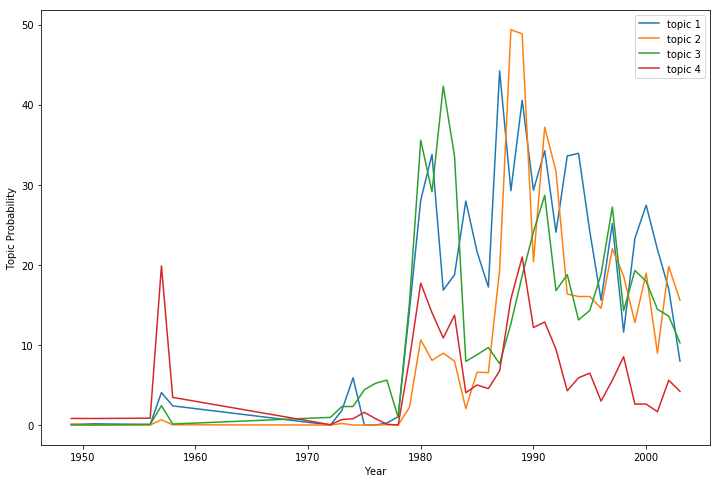

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(grouped_df_4['year'], grouped_df_4['t1'], label='topic 1')
plt.plot(grouped_df_4['year'], grouped_df_4['t2'], label='topic 2')
plt.plot(grouped_df_4['year'], grouped_df_4['t3'], label='topic 3')
plt.plot(grouped_df_4['year'], grouped_df_4['t4'], label='topic 4')
plt.xlabel("Year")
plt.ylabel("Topic Probability")
plt.legend(loc='best')
plt.show()

In [16]:
# print topic evolution
# evolution of 4th topic
fourth_topic = loaded_model_4.print_topic_times(topic=3) 
fourth_topic

[[('人', 0.014341673421349631),
  ('避孕', 0.010601296639950204),
  ('生育', 0.008596836571674623),
  ('生活', 0.005989094217049905),
  ('增加', 0.005884005114616439),
  ('问题', 0.005588108756243137),
  ('节育', 0.0054943323050211405),
  ('生产', 0.005455543564447924),
  ('农民', 0.004861132517332558),
  ('元', 0.004679680813619607),
  ('生', 0.004614035238053797),
  ('孩子', 0.004609708460107358),
  ('手术', 0.00460109642099046),
  ('农业', 0.004528563105632976),
  ('农村', 0.004028710116273473),
  ('工作', 0.004002050797893004),
  ('方法', 0.0038936522647892136),
  ('妇女', 0.003754485806564443),
  ('技术', 0.0037081293907655958),
  ('结婚', 0.003582474075604861)],
 [('人', 0.017214914874466546),
  ('生', 0.013326310710981726),
  ('孩子', 0.012558728642369893),
  ('元', 0.00903847965435901),
  ('岁', 0.007558626569064077),
  ('手术', 0.007294972180404443),
  ('节育', 0.0071780018338139665),
  ('少', 0.006344075731732248),
  ('妇女', 0.006074174871427685),
  ('农村', 0.005232627404481776),
  ('家庭', 0.005201036567795239),
  ('农民', 0.00

In [17]:
# evolution of 1st topic
second_topic = loaded_model_4.print_topic_times(topic=0) 
second_topic

[[('人口', 0.05404218744001199),
  ('我国', 0.017401062046863765),
  ('问题', 0.016607251314020483),
  ('发展', 0.012845328842023027),
  ('人民', 0.012785815860103054),
  ('国家', 0.011252045673946838),
  ('增长', 0.009988017976241596),
  ('经济', 0.008309216877554334),
  ('中国', 0.008270352145857288),
  ('世界', 0.00810141915115335),
  ('社会主义', 0.007842427744225194),
  ('人', 0.007658352756699413),
  ('生产', 0.006775355420276725),
  ('社会', 0.0066818304809534825),
  ('会议', 0.006648340589295479),
  ('新', 0.005614471731283247),
  ('建设', 0.005311073101686552),
  ('解决', 0.005299308980468389),
  ('政策', 0.004702643928184294),
  ('代表', 0.004673179894845756)],
 [('人口', 0.07190752407047625),
  ('增长', 0.01754852074661302),
  ('发展', 0.014066191434017066),
  ('我国', 0.01330284030571373),
  ('问题', 0.010652029273345975),
  ('中国', 0.010278380615789746),
  ('国家', 0.009918402326841559),
  ('控制', 0.009439941429905618),
  ('世界', 0.008341666706111523),
  ('经济', 0.008260011551223377),
  ('人', 0.006988933251894892),
  ('社会', 0.0

In [18]:
# evolution of 3rd topic
third_topic = loaded_model_4.print_topic_times(topic=2) 
third_topic

[[('工作', 0.04165914239345158),
  ('计划生育', 0.04085774605717969),
  ('群众', 0.0114880771617552),
  ('宣传', 0.01098270021292339),
  ('妇女', 0.009687049670147305),
  ('思想', 0.009220061465132974),
  ('领导', 0.008315155545659942),
  ('实行', 0.0068947957762637395),
  ('晚婚', 0.006528428380131969),
  ('主席', 0.006295270877564518),
  ('计划', 0.006266007463091066),
  ('开展', 0.006258088440299161),
  ('大队', 0.005787309322545268),
  ('加强', 0.005305295996265145),
  ('生育', 0.005266135985570806),
  ('各级', 0.00511915345859507),
  ('人口', 0.004986859806389253),
  ('干部', 0.004946577078749484),
  ('深入', 0.004943830348850614),
  ('新', 0.004910508784571493)],
 [('计划生育', 0.049282069600143065),
  ('工作', 0.03626760043640989),
  ('群众', 0.01288499985476238),
  ('人口', 0.009966677290613792),
  ('宣传', 0.009449450339292443),
  ('干部', 0.00869497507413538),
  ('生', 0.007521362278321094),
  ('实行', 0.0071713340181241226),
  ('思想', 0.006952603525653762),
  ('教育', 0.006806960208860831),
  ('生育', 0.006724985896918486),
  ('孩子', 0.0

In [19]:
# evolution of 2nd topic
second_topic = loaded_model_4.print_topic_times(topic=1) 
second_topic

[[('计划生育', 0.02363405617901945),
  ('人口', 0.02008864498613487),
  ('工作', 0.016117789385035733),
  ('生育', 0.012241238106840155),
  ('人', 0.008759568588346835),
  ('全省', 0.006725346260114552),
  ('万', 0.006310294200439744),
  ('管理', 0.005729281117214317),
  ('计划', 0.005562986352887434),
  ('胎', 0.005304098446499241),
  ('县', 0.005011591663522719),
  ('干部', 0.004980051483013643),
  ('超生', 0.0048599912690398175),
  ('流动', 0.004836026485563154),
  ('部门', 0.004787056424414768),
  ('出生', 0.004651895537778214),
  ('育龄', 0.004632025913687613),
  ('本报', 0.004506657280709081),
  ('人员', 0.00420861481294467),
  ('措施', 0.003914555174743302)],
 [('计划生育', 0.03334834290285728),
  ('人口', 0.014292071166250211),
  ('工作', 0.013758730904426525),
  ('生育', 0.011115746256354734),
  ('人', 0.009400734320731373),
  ('万', 0.007157519049156959),
  ('胎', 0.005777587696998984),
  ('超生', 0.005710721950715697),
  ('县', 0.005429952222338677),
  ('管理', 0.005402967500361836),
  ('计划', 0.005049359214278527),
  ('干部', 0.004

In [66]:
# fit the 3-topic model
start = time.time()
ldaseq_3 = ldaseqmodel.LdaSeqModel(corpus=corpus_all, id2word=dic_all, time_slice=time_slice, 
                                    num_topics=3, chain_variance=0.1, random_state=100)
end = time.time()
print(end - start)

/Users/ditong/anaconda3/lib/python3.6/site-packages/gensim/models/ldaseqmodel.py:230: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


3789.688334941864


In [67]:
# save model
pickle.dump(ldaseq_3, open("ldaseq_model_3.sav", 'wb'))
# check
loaded_model_3 = pickle.load(open("ldaseq_model_3.sav", 'rb'))

In [77]:
# calculate coherence matrix
topics_dtm_3 = ldaseq_3.dtm_coherence(time=0)
cm_DTM_3 = CoherenceModel(topics=topics_dtm_3, corpus=corpus_all, dictionary=dic_all, coherence='u_mass')
print ("U_mass topic coherence")
print ("DTM Python coherence is", cm_DTM_3.get_coherence())

U_mass topic coherence
DTM Python coherence is -1.2017161045941682


In [76]:
# calculate coherence matrix
topics_dtm_test = loaded_model_3.dtm_coherence(time=0)
cm_DTM_test = CoherenceModel(topics=topics_dtm_test, corpus=corpus_all, dictionary=dic_all, coherence='u_mass')
print ("U_mass topic coherence")
print ("DTM Python coherence is", cm_DTM_test.get_coherence())

U_mass topic coherence
DTM Python coherence is -1.2017161045941682
